In [1]:
import ipywidgets as widgets
from IPython.display import display

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import lal
import lalsimulation as lalsim

import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

import numpy as np
import pandas as pd

import phenom

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.signal import savgol_filter

<Figure size 640x480 with 0 Axes>

In [3]:
# from my old code: https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/oct2022/uncertainty/utils.py

def gen_td_modes_wf_params(
        m1=50,
        m2=50,
        S1x=0,
        S1y=0,
        S1z=0,
        S2x=0,
        S2y=0,
        S2z=0,
        distance=1,
        deltaT=1/4096,
        phiRef=0.,
        f_min=10,
        f_ref=10,
        LALpars=None,
        approximant=lalsim.SEOBNRv4P,
        lmax_dummy=2):
    """
    lmax_dummy {int: 2}: old option for XLALSimInspiralChooseTDModes.
    """

    p = dict(
        m1=m1,
        m2=m2,
        S1x=S1x,
        S1y=S1y,
        S1z=S1z,
        S2x=S2x,
        S2y=S2y,
        S2z=S2z,
        phiRef=phiRef,
        r=distance,
        deltaT=deltaT,
        f_min=f_min,
        f_ref=f_ref,
        LALpars=LALpars,
        lmax=lmax_dummy,
        approximant=approximant)

    return p


def gen_td_modes_wf(p, modes=[(2, 2)]):
    """
    input:
        p {dict} normally the output of gen_td_modes_wf_params
        modes {list of 2-tuples: [(2,2)]}
            modes to generate
            Note: Depending on the waveform model used
            you might need to explicitly provide both positive and
            negative modes.
    returns:
        times {array} in units of seconds
        hlms {dict} contains time domain hlm modes
    """
    p = p.copy()

    if (2, 2) not in modes:
        raise NotImplementedError("(2,2) mode not in modes.\
Currently we assume that this mode exists.")

    if p['LALpars'] is None:
        p['LALpars'] = lal.CreateDict()

    ma = lalsim.SimInspiralCreateModeArray()
    for l, m in modes:
        lalsim.SimInspiralModeArrayActivateMode(ma, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(p['LALpars'], ma)

    M = p['m1'] + p['m2']
    p.update({'m1': p['m1']*lal.MSUN_SI})
    p.update({'m2': p['m2']*lal.MSUN_SI})

    hlms_lal = lalsim.SimInspiralChooseTDModes(**p)

    hlms = {}

    for l, m in modes:
        tmp = lalsim.SphHarmTimeSeriesGetMode(hlms_lal, l, m)
        if l == 2 and m == 2:
            length_22 = tmp.data.length
            dt_22 = tmp.deltaT
            epoch_22 = tmp.epoch
        hlms.update({(l, m): tmp.data.data})

    assert p['deltaT'] == dt_22, f"input deltaT = {p['deltaT']} does not match waveform dt = {dt_22}."

    t = np.arange(length_22) * dt_22 + float(epoch_22)

    return t, hlms

In [4]:
p = gen_td_modes_wf_params(approximant=lalsim.SpinTaylorT1, S1x=0., m2=20)
# p = gen_td_modes_wf_params(S1x=0., m2=20)

In [5]:
def build_mode_array(lmin=2, lmax=4):
    ma=[]
    for l in range(lmin, lmax+1):
        for m in range(-l, l+1):
            ma.append((l,m))
    return ma

In [6]:
build_mode_array(lmax=4)

[(2, -2),
 (2, -1),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, -3),
 (3, -2),
 (3, -1),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (4, -4),
 (4, -3),
 (4, -2),
 (4, -1),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [7]:
modes = build_mode_array(lmax=4)
t, hlms = gen_td_modes_wf(p, modes=modes)

In [8]:
mtotal = p['m1'] + p['m2']
tM = phenom.StoM(t, mtotal)

In [9]:
hlms.keys()

dict_keys([(2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)])

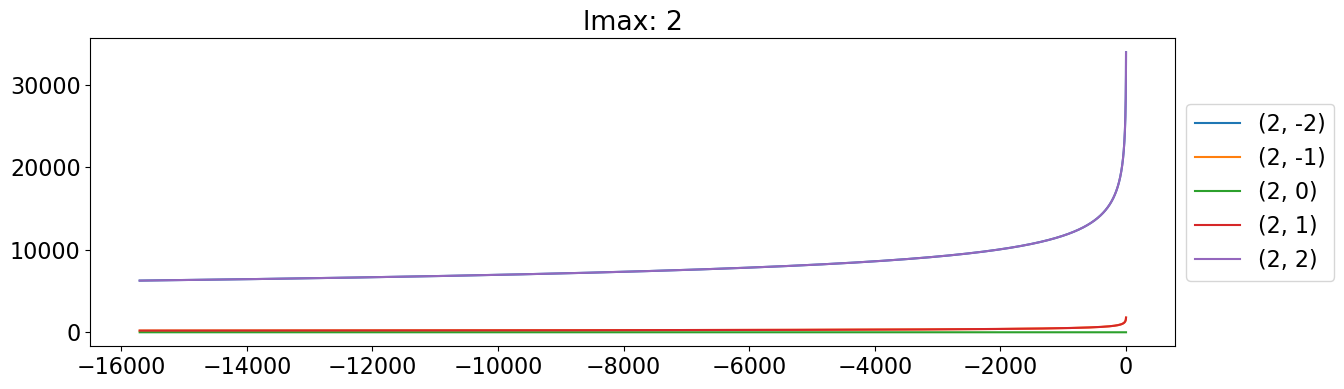

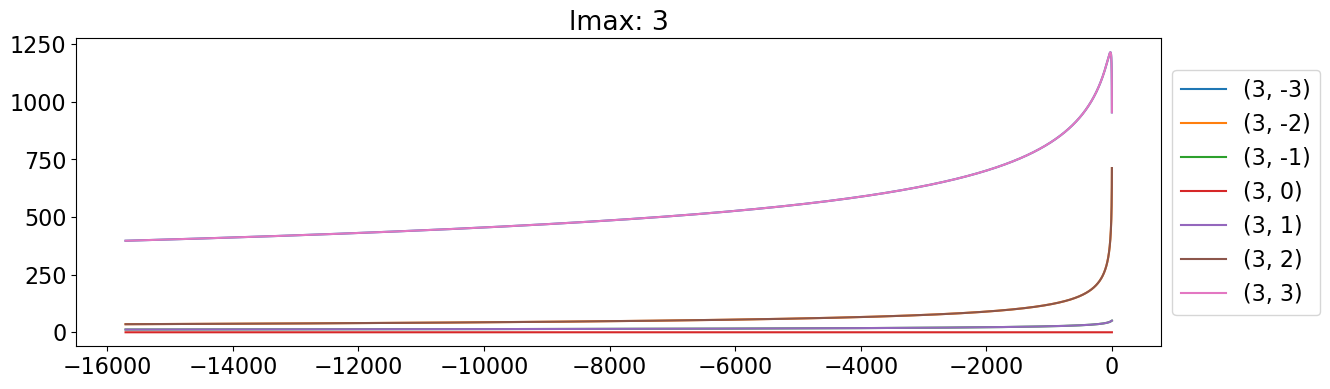

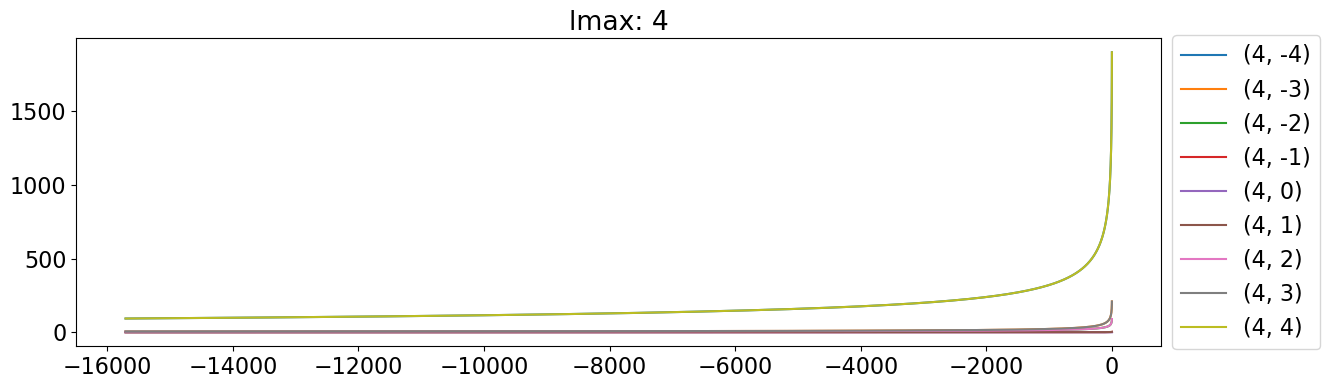

In [10]:
for lmax in [2,3,4]:
    plt.figure(figsize=(14,4))
    for lm in build_mode_array(lmin=lmax, lmax=lmax):
        plt.plot(tM, np.abs(hlms[lm]), label=lm)
    plt.title(f'lmax: {lmax}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
# example api
# waveform(hlms: dict, times: array)
# waveform.to_interial
# waveform.to_coprecessing
# waveform.shift(dt=0.1M, dphi_orb=0.2rad, dpsi=1.2rad, (inclination?)) # static shift of waveform
# waveform.rotate(alpha, beta, (gamma?)) # static rotation of modes
# combine the above two?

In [12]:
def generate_examples_waveforms():
    """
    generate a PN waveform and an IMR waveform to use to develop hybrid code
    """
    modes = [(2,2), (2,1), (3,3)]
    m1=50
    m2=40
    S1z=0.
    S2z=0.
    mtotal = m1+m2
    # waveform 1: PN
    wf1={}
    wf1['p'] = gen_td_modes_wf_params(approximant=lalsim.SpinTaylorT1, m1=m1, m2=m2, S1z=S1z, S2z=S2z)
    t, wf1['hlms'] = gen_td_modes_wf(wf1['p'], modes=modes)
    wf1['t'] = phenom.StoM(t, mtotal)
    # waveform 2: IMR
    wf2 = {}
    # lalsim.SEOBNRv4PHM
    wf2['p'] = gen_td_modes_wf_params(approximant=lalsim.SEOBNRv4PHM, m1=m1, m2=m2, f_min=13, S1z=S1z, S2z=S2z)
    t, wf2['hlms'] = gen_td_modes_wf(wf2['p'], modes=modes)
    wf2['t'] = phenom.StoM(t, mtotal)
    return wf1, wf2

In [13]:
wf1, wf2 = generate_examples_waveforms()

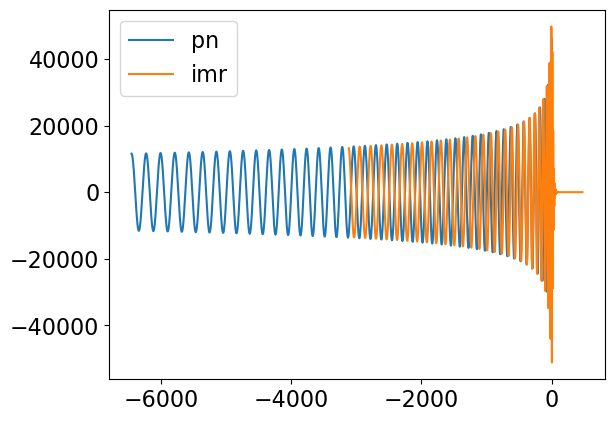

In [14]:
plt.plot(wf1['t'], wf1['hlms'][(2,2)].real, label='pn')
plt.plot(wf2['t'], wf2['hlms'][(2,2)].real, label='imr')
# plt.xlim(-1000, 100)
plt.legend()

In [15]:
plt.plot(wf1['t'], wf1['hlms'][(2,1)].real, label='pn')
plt.plot(wf2['t'], wf2['hlms'][(2,1)].real, label='imr')
# plt.xlim(-1000, 100)
plt.legend()

In [16]:
class ComplexMultipoleTimeSeries:
    """
    this class abstracts the complex time series of a waveform that been represented in at least the dominant l=m=2 multipole but
    possibly more sub-dominant multipoles.
    """
    def __init__(self, times, hlms):
        """
        times and hlms should be the base arrays that are worked on and then compute derivated quantities?
        would be better to work with any representation and compute any other representations
        e.g. real/imag or amp/phase or amp/freq
        """
        self.times = times
        self.hlms = hlms

        self.compute_derivated_quantities()


    def mask(self, t_start, t_end):
        mask = np.where( (self.times >= t_start) & (self.times <= t_end) )
        self.times = self.times[mask]
        for k in self.hlms.keys():
            self.hlms[k] = self.hlms[k][mask]
        self.compute_derivated_quantities()

    
    def compute_derivated_quantities(self):
        self.compute_amplitude()
        self.compute_phase()
        self.compute_frequency()

    def compute_amplitude(self):
        amps = {}
        for k in self.hlms.keys():
            amps[k] = np.abs(self.hlms[k])
        self.amps = amps
        
    def compute_phase(self):
        phases = {}
        for k in self.hlms.keys():
            phases[k] = np.unwrap(np.angle(self.hlms[k]))
        self.phases = phases
        
    def compute_frequency(self, filter_params=None):
        """
        filter_params: dict with keys: 'window_length' in terms of number of samples and 'polyorder'
        """
        freqs = {}
        for k in self.hlms.keys():
            freqs[k] = IUS(self.times, self.phases[k]).derivative()(self.times)
            if filter_params != None:
                freqs[k] = savgol_filter(freqs[k], filter_params['window_length'], filter_params['polyorder'])            
        self.freqs = freqs

In [17]:
ts1 = ComplexMultipoleTimeSeries(wf1['t'], wf1['hlms'])

ts2 = ComplexMultipoleTimeSeries(wf2['t'], wf2['hlms'])
ts2.mask(ts2.times[0], 100)

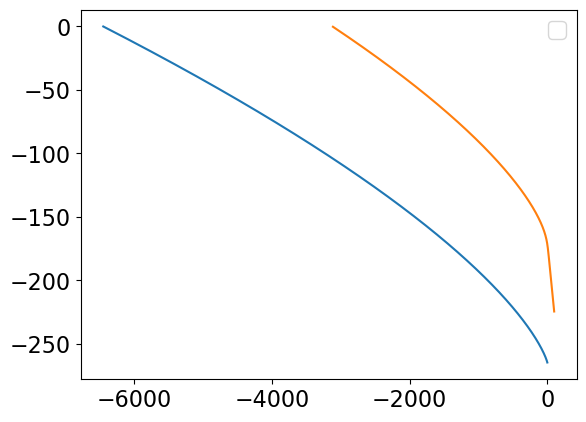

In [18]:
plt.plot(ts1.times, ts1.phases[(2,2)])
plt.plot(ts2.times, ts2.phases[(2,2)])
# plt.plot(ts2.times - 100, ts2.phases[(2,2)]-100, label='shifted')
plt.legend()
# plt.xlim(0, 100)

In [19]:
def align_phases(ts1, ts2, window_start, window_end):
    """
    fix ts1 and vary ts2
    """
    # interpolate onto common times? just zero pad the shorter one?

    # assuming uniform sampling and ordered time array
    duration1 = ts1.times[-1] - ts1.times[0]
    duration2 = ts2.times[-1] - ts2.times[0]

    print(duration1)
    print(duration2)

    # iphase1 = IUS(ts1.times, ts1.phases[(2,2)])
    # iphase2 = IUS(ts2.times + dt, ts2.phases[(2,2)] + dphi)

In [20]:
align_phases(ts1, ts2, 1,1)

6453.0412372245155
3215.2304124704892


In [21]:
@widgets.interact(dt=(-100, 100), dphi=(-100, 100))
def plot(dt=-102.67357057, dphi=-36.63596062):
    iphase1 = IUS(ts1.times, ts1.phases[(2,2)])
    y1 = iphase1(ts1.times)
    iphase2 = IUS(ts2.times, ts2.phases[(2,2)])
    y2 = iphase2(ts2.times+dt)+dphi

    x1 = ts1.times
    x2 = ts2.times
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    axs[0].plot(x1, y1)
    axs[0].plot(x2, y2)

    # common times
    common_times = np.linspace(x2[0], -100, 100)
    y1_ = iphase1(common_times)
    y2_ = iphase2(common_times+dt)+dphi

    axs[1].plot(common_times, y1_-y2_)

interactive(children=(IntSlider(value=-100, description='dt', min=-100), IntSlider(value=-36, description='dph…

In [22]:
# from TD
# https://bitbucket.org/dietrichtim/dynnrtidal/src/master/NR_comparison/BAM1.py
from scipy.optimize import minimize
import scipy.integrate

# win1=-2000
# win2=-1500

# win1=-3500
# win2=-1500

window_center = -1500
window_size = 1000
win1 = window_center - window_size/2
win2 = window_center + window_size/2
print(win1, win2)

iphase1 = IUS(ts1.times, ts1.phases[(2,2)], ext=3)
iphase2 = IUS(ts2.times, ts2.phases[(2,2)], ext=3)

# to do multi-mode hybrids could fit two modes simultaneously
def dephasing(z):
    dt, dphi = z
    # return scipy.integrate.quad(lambda t: np.abs( (iphase1(t) - (iphase2(t+dt)+dphi)) ), win1, win2, limit=100, epsabs=1e-5, epsrel=1e-5)[0]
    return scipy.integrate.quad(lambda t: np.abs( (iphase1(t) - (iphase2(t+dt)+dphi)) ), win1, win2, limit=100, epsabs=1e-7, epsrel=1e-7)[0]
    # return scipy.integrate.fixed_quad(lambda t: np.abs( (iphase1(t) - (iphase2(t+dt)+dphi)) ), win1, win2, n=20)[0]

mini = minimize(dephasing, [-5, -100],  tol=1e-12).x

-2000.0 -1000.0


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_38800/1788567951.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(lambda t: np.abs( (iphase1(t) - (iphase2(t+dt)+dphi)) ), win1, win2, limit=100, epsabs=1e-7, epsrel=1e-7)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_38800/1788567951.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(lambda t: np.abs( (iphase1(t) - (iphase2(t+dt)+dphi)) ), win1, win2, limit=100, epsabs=1e-7, epsrel=1e-7)[0]


In [23]:
mini

array([ -94.70265646, -107.2869697 ])

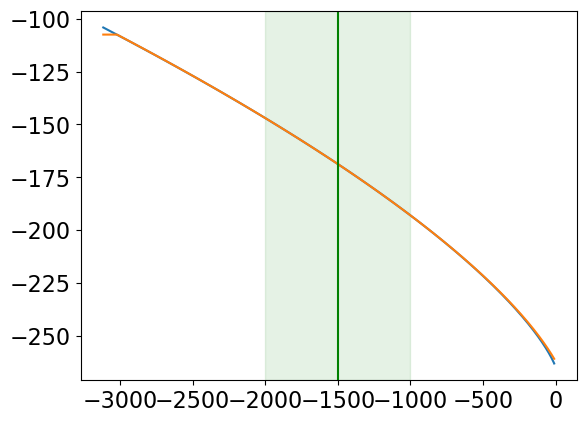

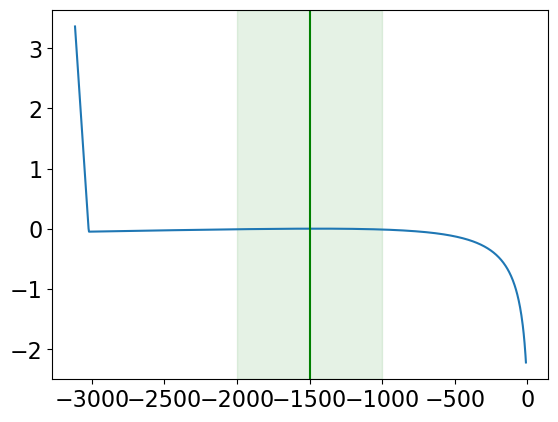

In [24]:
new_times = np.linspace(ts2.times[0], -10, 1000)
plt.figure()
plt.plot(new_times, iphase1(new_times))
plt.plot(new_times, iphase2(new_times+mini[0])+mini[1])
plt.axvspan(xmin=win1, xmax=win2, alpha=0.1, color='g')
plt.axvline(window_center, c='g')

plt.figure()
plt.plot(new_times, iphase1(new_times) - (iphase2(new_times+mini[0])+mini[1]))
plt.axvspan(xmin=win1, xmax=win2, alpha=0.1, color='g')
plt.axvline(window_center, c='g')

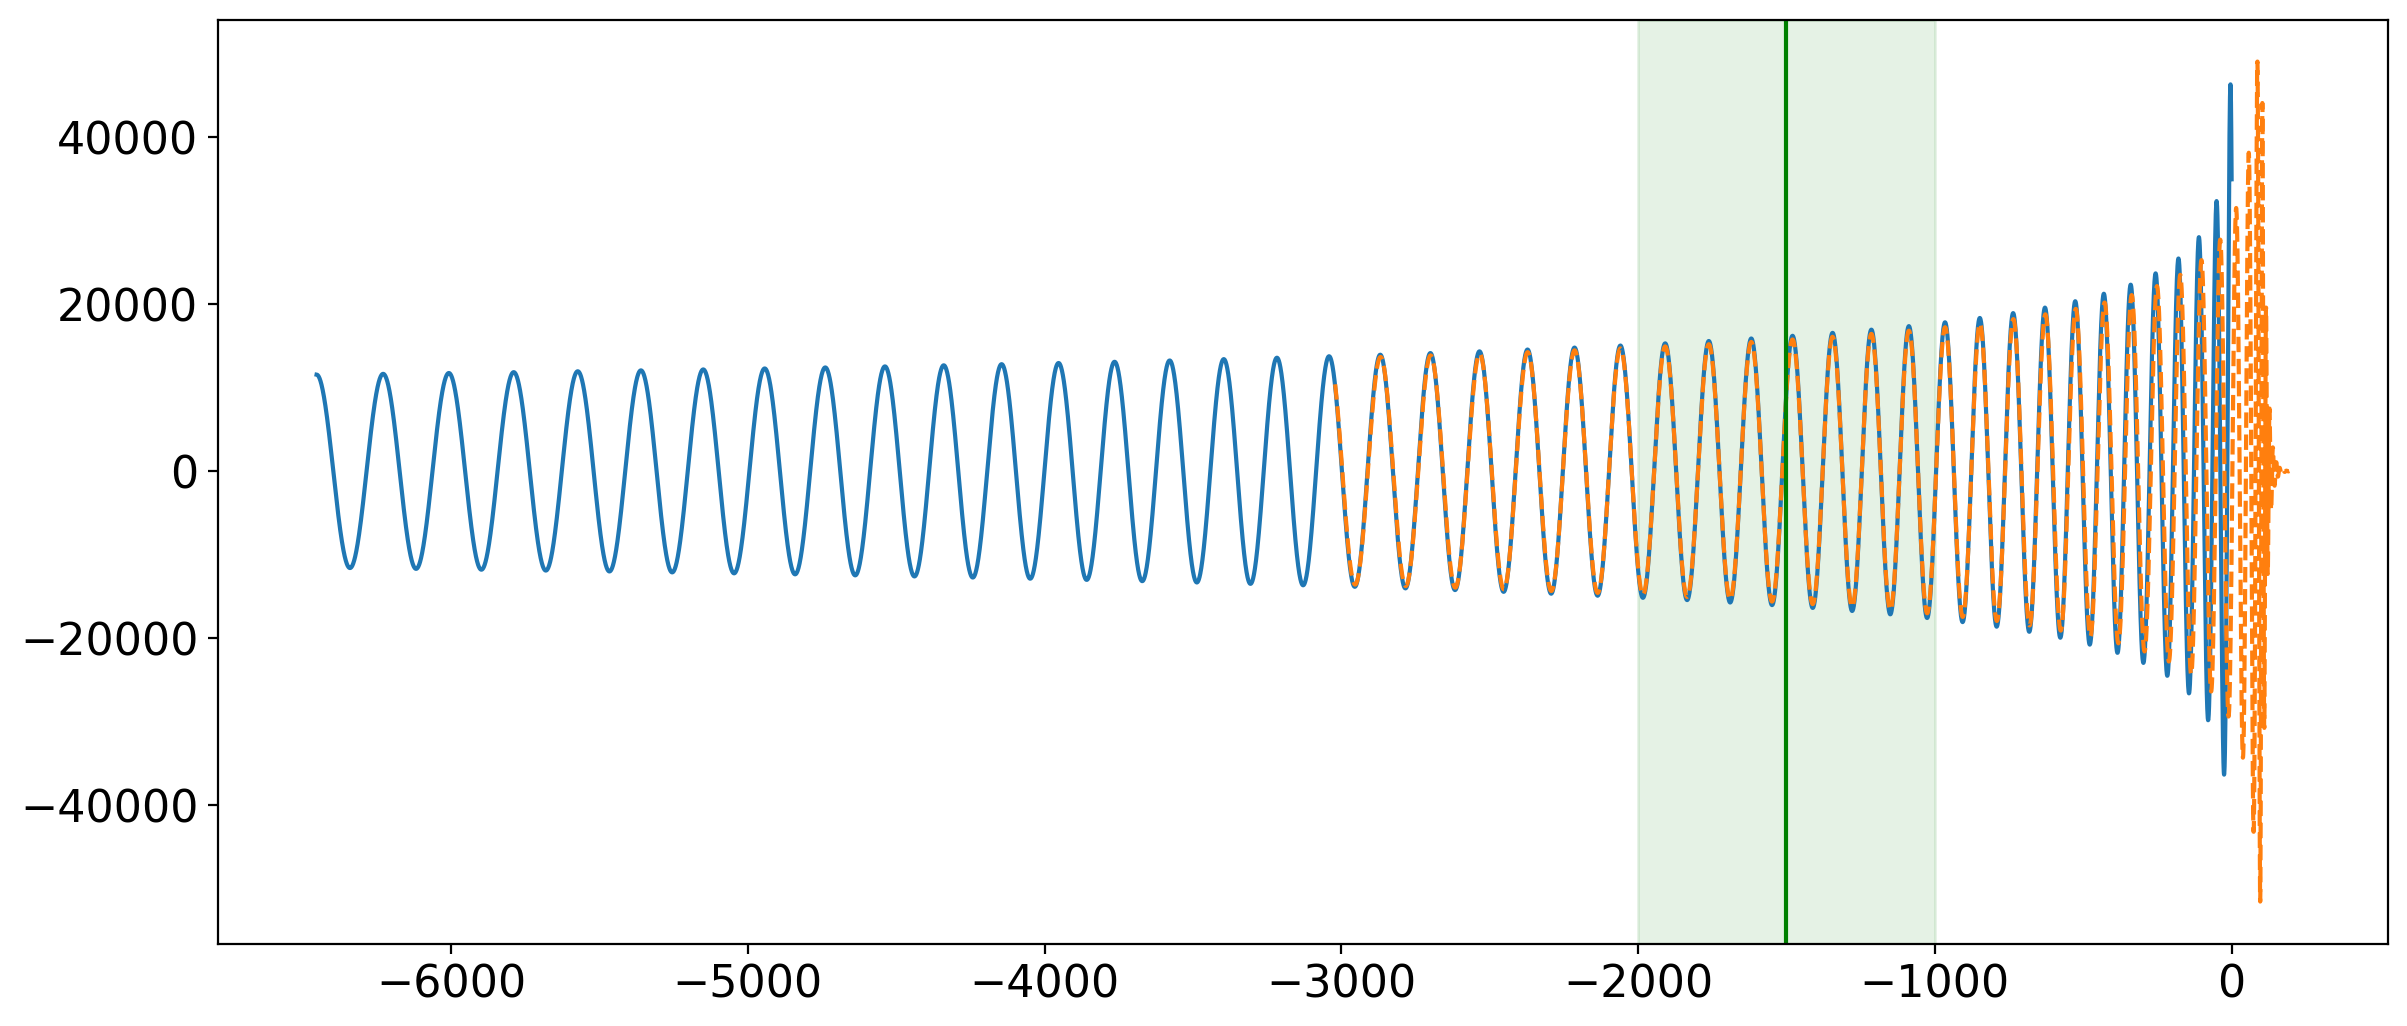

In [25]:
plt.figure(figsize=(14,6), dpi=200)
plt.plot(ts1.times, ts1.hlms[2,2].real)
plt.plot(ts2.times - mini[0], (ts2.hlms[2,2] * np.exp(1.j*mini[1])).real, ls='--')
# plt.xlim(-5000,200)
# plt.xlim(-9000, 200)

plt.axvspan(xmin=win1, xmax=win2, alpha=0.1, color='g')
plt.axvline(window_center, c='g')

# hybridisation using lmfit

interpreting hybridisation as a fitting problem

In [26]:
import lmfit

In [27]:
def HybridPhaseModel(x, dt, dphi, iNR=None):
    """
    takes the NR phase function and adds time and phase shift.
    we will fit this aginst PN data.
    """
    return iNR(x+dt)+dphi

In [28]:
iphase1 = IUS(ts1.times, ts1.phases[(2,2)], ext=3)

# ts2.times = ts2.times+1000

iphase2 = IUS(ts2.times, ts2.phases[(2,2)], ext=3)

model = lmfit.Model(HybridPhaseModel, iNR=iphase2)

In [29]:
model.independent_vars

['x']

In [30]:
model.param_names

['dt', 'dphi']

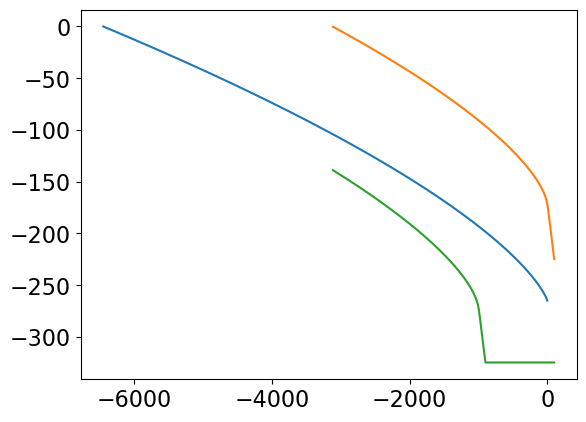

In [31]:
plt.plot(ts1.times, iphase1(ts1.times))
plt.plot(ts2.times, model.eval(x=ts2.times, dt=0, dphi=0))
plt.plot(ts2.times, model.eval(x=ts2.times, dt=1000, dphi=-100))

In [32]:
params = model.make_params(
                dt=dict(value=0),
                dphi=dict(value=-1000),
        )


In [33]:
params

Parameters([('dt', <Parameter 'dt', value=0, bounds=[-inf:inf]>), ('dphi', <Parameter 'dphi', value=-1000, bounds=[-inf:inf]>)])

In [34]:
win1 = -2000
win2 = -1000
mask = np.where( (ts1.times>=win1) & (ts1.times<=win2) )
result = model.fit(iphase1(ts1.times[mask]), params, x=ts1.times[mask])

In [35]:
result

In [36]:
result.plot_fit()

<Axes: title={'center': 'Model(HybridPhaseModel)'}, xlabel='x', ylabel='y'>

<Axes: title={'center': 'Model(HybridPhaseModel)'}, ylabel='residuals'>

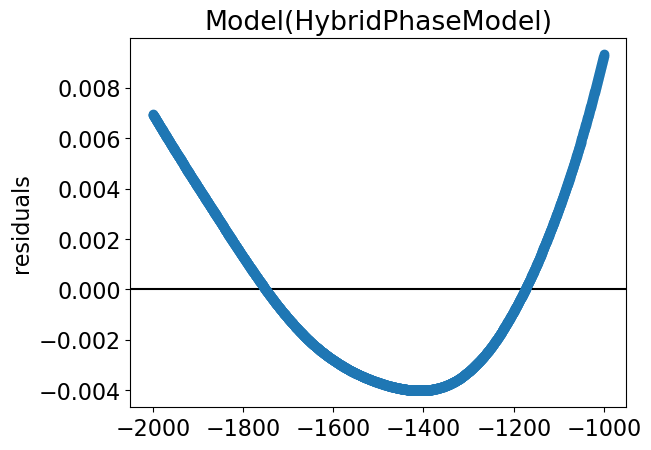

In [37]:
result.plot_residuals()

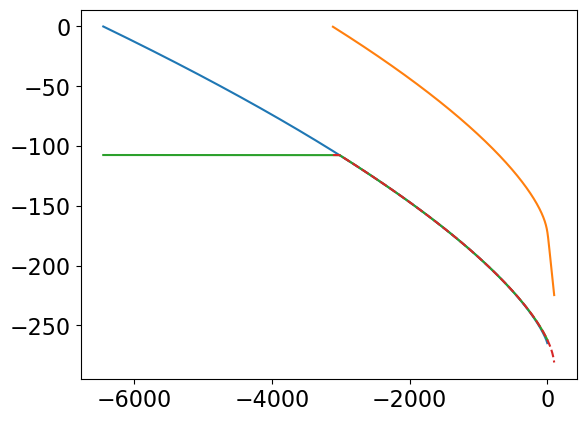

In [38]:
plt.plot(ts1.times, iphase1(ts1.times))
plt.plot(ts2.times, iphase2(ts2.times))
plt.plot(ts1.times, model.eval(result.params, x=ts1.times))
plt.plot(ts2.times, model.eval(result.params, x=ts2.times), ls='--')

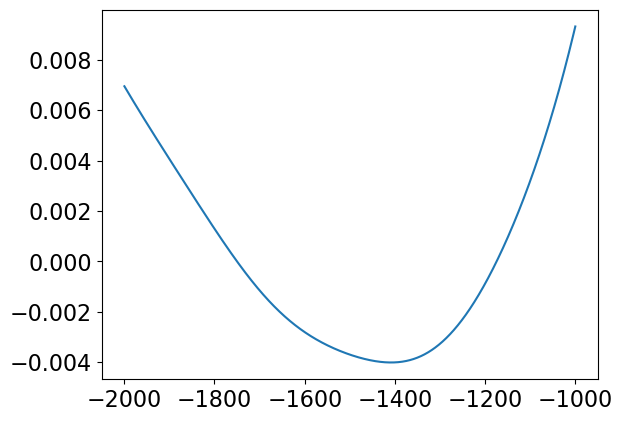

In [39]:
plt.plot(ts1.times[mask], model.eval(result.params, x=ts1.times[mask])-iphase1(ts1.times[mask]))

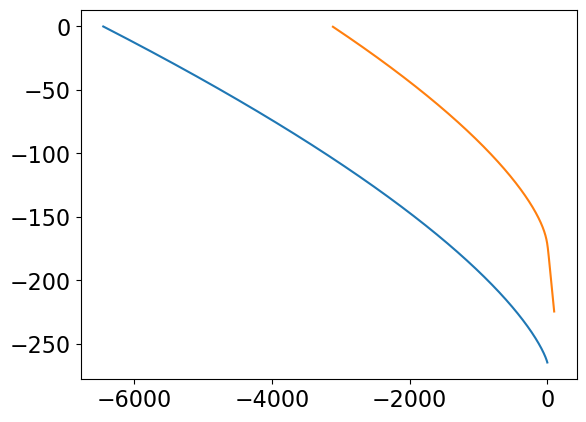

In [40]:
plt.plot(ts1.times, ts1.phases[2,2])
plt.plot(ts2.times, ts2.phases[2,2])

In [41]:
# using minimizer?

In [42]:
def residual(pars, x, idata, iNR, win1, win2):
    mask = np.where( (x>=win1) & (x<=win2) )
    model = HybridPhaseModel(x, pars['dt'], pars['dphi'], iNR)
    return model[mask] - idata(x)[mask]

In [43]:
mini = lmfit.Minimizer(residual, params, fcn_args=(ts1.times, iphase1, iphase2, win1, win2))

In [44]:
out = mini.leastsq()
out

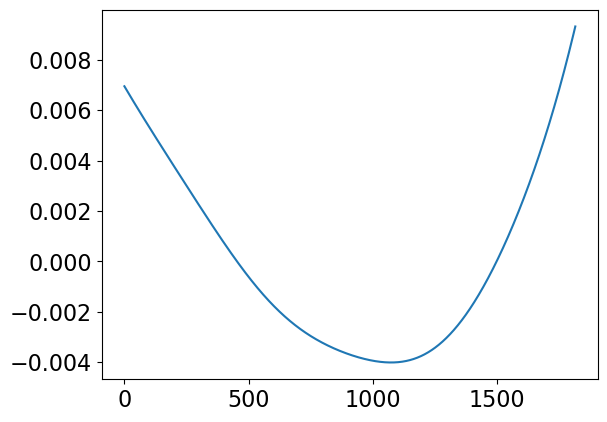

In [45]:
plt.plot(out.residual)

# fit complex?

In [46]:
def HybridModel(x, dt, dphi, hlm_nr_x=None, hlm_nr_y=None):

    i_hlm_real = IUS(hlm_nr_x, hlm_nr_y.real, ext=3)
    i_hlm_imag = IUS(hlm_nr_x, hlm_nr_y.imag, ext=3)

    z = i_hlm_real(x+dt) + 1.j*i_hlm_imag(x+dt)
    
    return z * np.exp(1.j*dphi)

In [47]:
model = lmfit.Model(HybridModel, hlm_nr_x=ts2.times, hlm_nr_y=ts2.hlms[2,2])

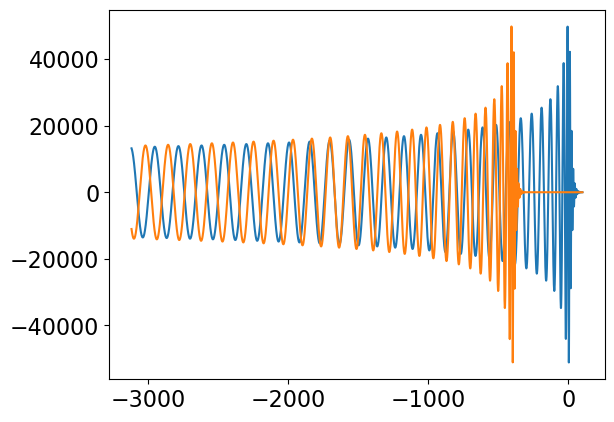

In [48]:
plt.plot(ts2.times, model.eval(x=ts2.times, dt=0, dphi=0).real)
plt.plot(ts2.times, model.eval(x=ts2.times, dt=400, dphi=0).real)
# plt.xlim(-100, 100)

In [49]:
params = model.make_params(
                dt=dict(value=0),
                dphi=dict(value=0),
        )


In [50]:
win1 = -2000
win2 = -1000
mask = np.where( (ts1.times>=win1) & (ts1.times<=win2) )
result = model.fit(ts1.hlms[2,2][mask], params, x=ts1.times[mask])

In [51]:
result

<Axes: title={'center': 'Model(HybridModel)'}, xlabel='x', ylabel='y'>

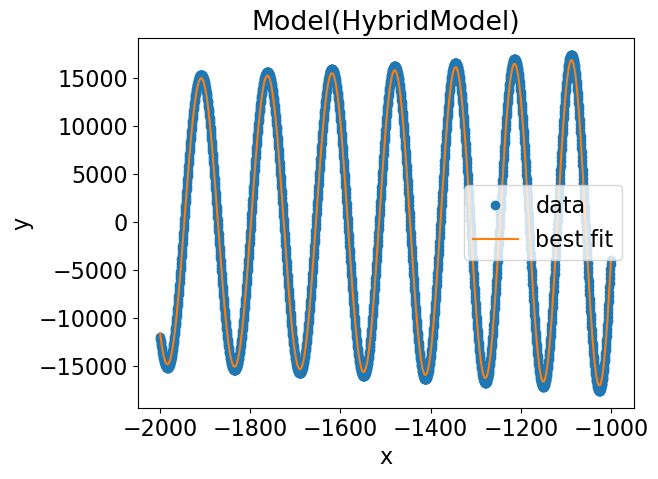

In [52]:
result.plot_fit(parse_complex='real')

In [53]:
new_x = np.linspace(ts2.times[0]-result.params['dt'], ts2.times[-1]-result.params['dt'], 5000)

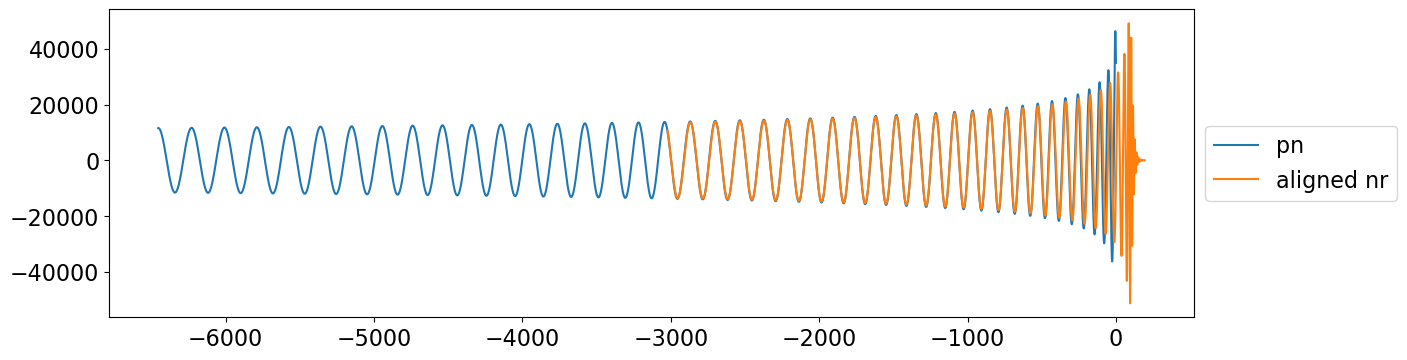

In [54]:
plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[2,2].real, label='pn')
plt.plot(new_x, model.eval(x=new_x, params=result.params).real, label='aligned nr')
# plt.plot(new_x, np.abs(model.eval(x=new_x, params=result.params)))
# plt.xlim(-100, 200)
# plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

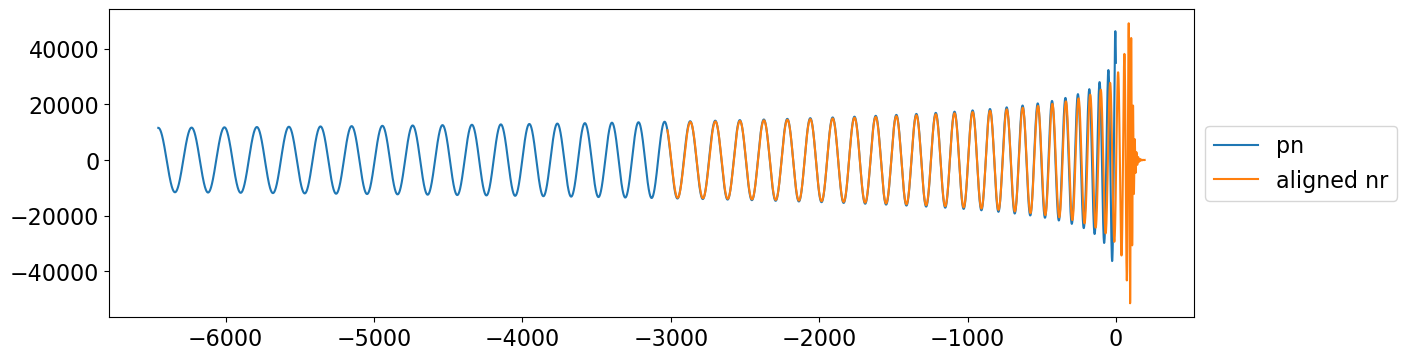

In [55]:
plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[2,2].real, label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']

plt.plot(ts2.times-dt_, (ts2.hlms[2,2]*np.exp(1.j*dphi_)).real, label='aligned nr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

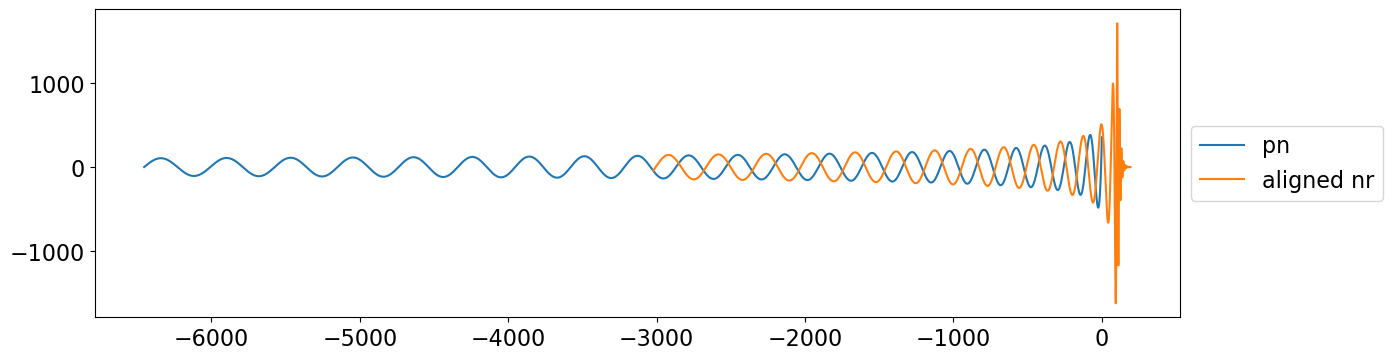

In [56]:
# this shows that we need to fit for the polarisation angle
plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[2,1].real, label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']

plt.plot(ts2.times-dt_, (ts2.hlms[2,1]*np.exp(-1.j*dphi_)).real, label='aligned nr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fit multiple modes

in lmfit this is fitting a complex, multiple-data dataset.

In [57]:
# https://lmfit.github.io/lmfit-py/faq.html#how-can-i-fit-multiple-data-sets
# fit multiple modes by concatenating them

In [58]:
def MultimodeHybridModel(x, dt, dphi, dpsi, hlm_nr_x=None, hlm_nr_y=None):
    """
    hlm_nr_y: dict of modes
    """
    lms = list(hlm_nr_y.keys())
    i_hlm_real={}
    i_hlm_imag={}
    
    for k in lms:
        i_hlm_real[k] = IUS(hlm_nr_x, hlm_nr_y[k].real, ext=3)
        i_hlm_imag[k] = IUS(hlm_nr_x, hlm_nr_y[k].imag, ext=3)



    zs = []
    for k in lms:
        m = k[1]
        # not 100% on sign of imaginary part here
        z = i_hlm_real[k](x+dt) + 1.j*i_hlm_imag[k](x+dt)
        z *= np.exp(1.j*m*dphi)
        z *= np.exp(1.j*2*dpsi)
        zs.append(z)
        
    
    return np.concatenate(zs)

In [59]:
def estimate_time_shift(t1, f1, t2, f2):
    """
    given then time and frequncy of two waveforms
    find the time in `t1` where the frequency `f1`
    equals the initial frequency of `f2`.
    
    this function is quite strict and will only work
    if f(t) can be inverted.

    input:
        t1: time array for waveform 1
        f1: frequency array for waveform 1
        t2: time array for waveform 2
        f2: frequency array for waveform 2

    returns:
        dt: time shift to apply to t2
        pn_time_of_nr: the time in t1 coordindates where f1 = f2[0]
    """
    # note: most of this code is redundent e.g. we only need
    # to interpolate t(-f) for PN only.
    # also PN waveforms are more likely to be long
    # so we can cut costs by only interpolating a subset of the data.
    # e.g. only the last half.
    
    # f(t)
    ifreq1 = IUS(t1, f1)
    ifreq2 = IUS(t2, f2)

    # t(-f)
    itimes1 = IUS(-f1, t1)
    itimes2 = IUS(-f2, t2)

    # negative sign because t(-f) interpolation
    # f2[0] can become an input frequency that we want to match at.
    nr_initial_frequency = -f2[0]
    # pn time of nr initial frequency
    pn_time_of_nr = itimes1(nr_initial_frequency)
    # time shift required to shift NR times to align
    # them such that the pn and nr frequencies are equal
    # at the NR initial frequency but on the PN time axis.
    dt_ = t2[0] - pn_time_of_nr
    return dt_, float(pn_time_of_nr)

In [60]:
dt_, pn_time_of_nr = estimate_time_shift(ts1.times, ts1.freqs[2,2], ts2.times, ts2.freqs[2,2])

In [61]:
# we can use this as the basis of the start window
# the end window we take to be 3 orbits later
pn_time_of_nr

-3009.760793297052

In [62]:
def estimate_window_from_phase(times, phase, t0, n_cycles_before_window, n_cyles_in_window):
    """
    times
    phase
    t0: time of start of waveform
    n_cycles_before_window: number of GW cycles after t0 and then the hybridisation windown starts
    n_cyles_in_window: number of GW cycles in hybridisation window

    returns
    win1: start of window (M)
    win2: end of window (M)
    """

    # if it becomes an issue to interpolate this
    # e.g. non-monotonicity then we could fit
    # a cubic to the first half of the NR or some other ansatz
    # to try and get an approximation
    
    i_phi_of_t = IUS(times, phase)
    # flip sign of phase to interpolate
    i_t_of_phi = IUS(-phase, times)

    phase_at_t0 = float(i_phi_of_t(t0))

    win1_phase = -phase_at_t0 + n_cycles_before_window*2*np.pi
    win2_phase = win1_phase + n_cyles_in_window*2*np.pi
    win1 = i_t_of_phi(win1_phase)
    win2 = i_t_of_phi(win2_phase)

    return float(win1), float(win2)

In [63]:
win1, win2 = estimate_window_from_phase(
    ts2.times - dt_,
    ts2.phases[2,2],
    t0=pn_time_of_nr,
    n_cycles_before_window=2,
    n_cyles_in_window=6)
win1, win2

(-2669.620416599851, -1734.7550737014062)

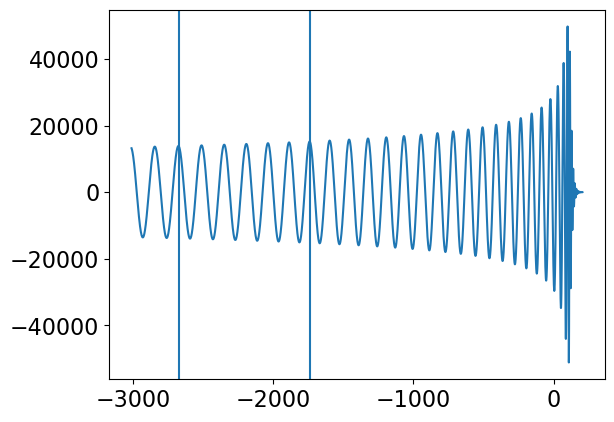

In [64]:
plt.plot(ts2.times - dt_, ts2.hlms[2,2].real)
plt.axvline(win1)
plt.axvline(win2)

In [65]:
dt_

-105.78804987321291

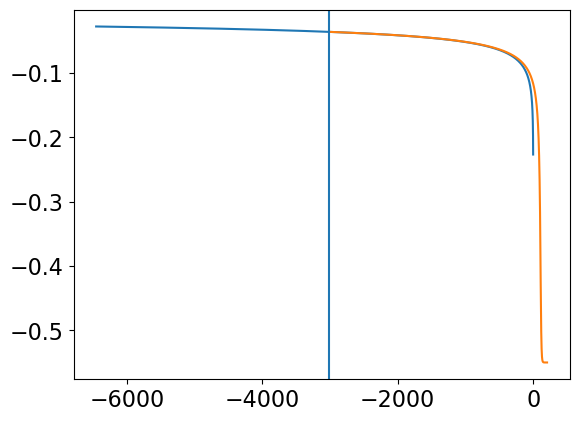

In [66]:
plt.plot(ts1.times, ts1.freqs[2,2])
# plt.plot(ts2.times, ts2.freqs[2,2])
plt.plot(ts2.times - dt_, ts2.freqs[2,2])
plt.axvline(pn_time_of_nr)
# plt.xlim(pn_time_of_nr-100, pn_time_of_nr+100)
# plt.ylim(-0.1, 0)

In [67]:
# normalise each mode by max(abs(hlm))
# this might make it easier to fit
# and we are not fitting anything amplitude related
# only time shift and rotations.
# this will only make the amplitudes between NR and PN approximately the same
normalise_modes=True
hlm_nr_x = ts2.times
if normalise_modes == True:
    ts2_hlms_norm={}
    for k in ts2.hlms.keys():
        ts2_hlms_norm[k] = ts2.hlms[k] / np.max(np.abs(ts2.hlms[k]))

    hlm_nr_y=ts2_hlms_norm
else:
    hlm_nr_y=ts2.hlms
    
model = lmfit.Model(MultimodeHybridModel, hlm_nr_x=hlm_nr_x, hlm_nr_y=hlm_nr_y)


In [68]:
plt.plot(model.eval(x=ts2.times, dt=0, dphi=0, dpsi=0).real)
plt.plot(model.eval(x=ts2.times, dt=100, dphi=0, dpsi=0).real)

In [129]:
# need to fit each waveform multiple times
# with either dpsi fixed to either 0 or pi/2
# and then with random dphis to avoid local minima
# pick the model with smallest redchis
params = model.make_params(
                dt=dict(value=dt_),
                dphi=dict(value=-2.5),
                dpsi=dict(value=0, vary=False) # only allowed values 0, pi/2 (and pi, this is degenerate with 0)?
        )


In [130]:
# win1 = -15000
# win2 = -10000

# set window using times of NR waveform. Probably only works if both PN and NR are somewhat aligned - improve this in the future.
# the start windown should be the time that the PN frequency approximately equals the NR ~start frequency
# win1 = ts2.times[0]+500
# win2 = win1+1000

# win1 = -3000
# win2 = -2000

# win1 = -2000
# win2 = -1000
mask = np.where( (ts1.times>=win1) & (ts1.times<=win2) )

# x_fit = np.row_stack([ts1.times[mask],ts1.times[mask]])
x_fit = ts1.times[mask]

# it seems like a good idea to normalise the modes when fitting
# turn this into a function
if normalise_modes == True:
    max_abs = lambda x: np.max(np.abs(x))
    # y_fit = np.concatenate([ts1.hlms[2,2][mask]/max_abs(ts1.hlms[2,2][mask]),ts1.hlms[2,1][mask]/max_abs(ts1.hlms[2,1][mask]),ts1.hlms[3,3][mask]/max_abs(ts1.hlms[3,3][mask])])
    y_fit = np.concatenate([ts1.hlms[2,2][mask]/max_abs(ts1.hlms[2,2]),ts1.hlms[2,1][mask]/max_abs(ts1.hlms[2,1]),ts1.hlms[3,3][mask]/max_abs(ts1.hlms[3,3])])
else:
    y_fit = np.concatenate([ts1.hlms[2,2][mask],ts1.hlms[2,1][mask],ts1.hlms[3,3][mask]])



result = model.fit(y_fit, params, x=x_fit)

In [131]:
plt.plot(x_fit, ts1.hlms[2,2][mask].real/np.abs(ts1.hlms[2,2][mask]).max())
plt.plot(x_fit, ts1.hlms[2,1][mask].real/np.abs(ts1.hlms[2,1][mask]).max())
plt.plot(x_fit, ts1.hlms[3,3][mask].real/np.abs(ts1.hlms[3,3][mask]).max())

In [132]:
result

In [133]:
# result.plot_residuals(parse_complex='real')
# result.plot_fit(parse_complex='real')

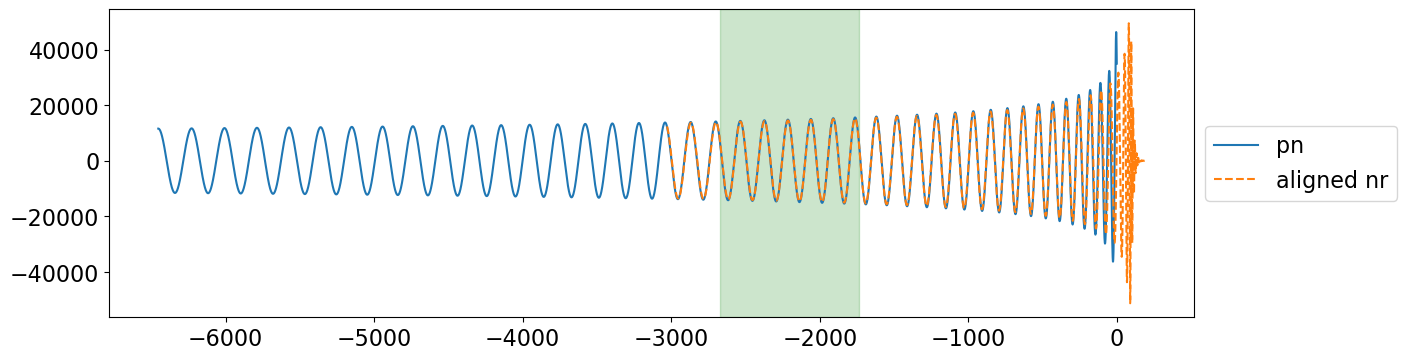

In [134]:
ell=2
mm=2

plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[ell,mm].real, label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']
dpsi_ = result.params['dpsi']

plt.plot(ts2.times-dt_, (ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).real, label='aligned nr', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvspan(win1, win2, color='g', alpha=0.2)

# plt.xlim(win1+10000, win2+1000)

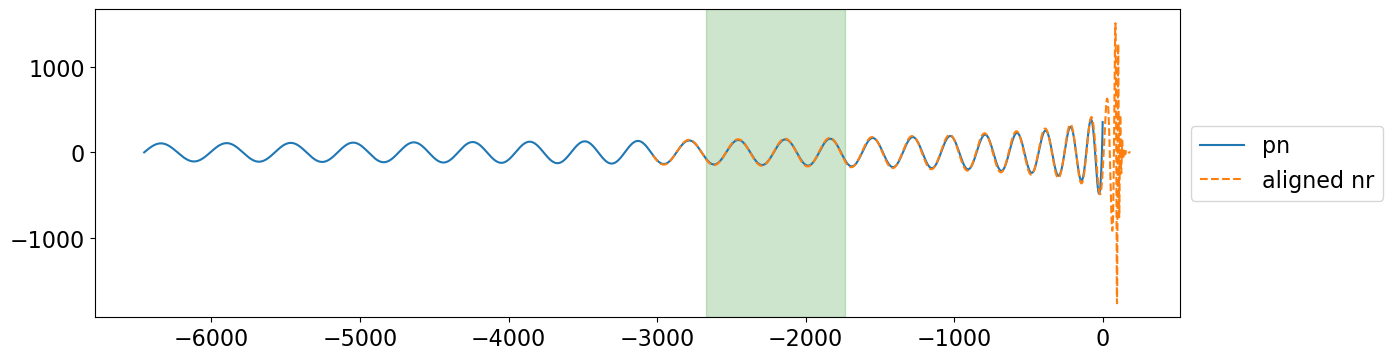

In [135]:
ell=2
mm=1

plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[ell,mm].real, label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']
dpsi_ = result.params['dpsi']


plt.plot(ts2.times-dt_, (ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).real, label='aligned nr', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvspan(win1, win2, color='g', alpha=0.2)

# plt.xlim(win1+10000, win2+1000)

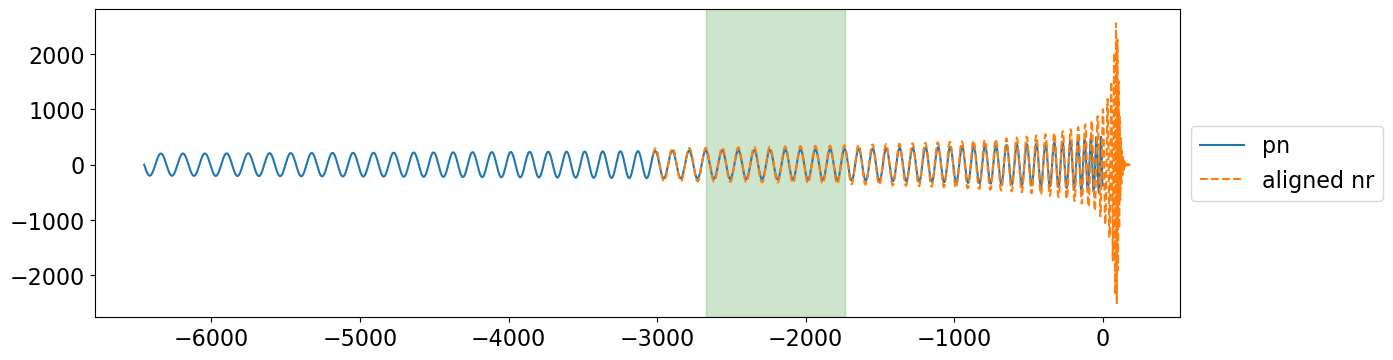

In [136]:
ell=3
mm=3

plt.figure(figsize=(14,4))
plt.plot(ts1.times, ts1.hlms[ell,mm].real, label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']
dpsi_ = result.params['dpsi']


plt.plot(ts2.times-dt_, (ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).real, label='aligned nr', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axvspan(win1, win2, color='g', alpha=0.2)


# plt.xlim(win1+10000, win2+1000)

In [137]:
def plot_hybrid(ts1, ts2, ell, mm, result, win1, win2, xlim=None):
    dt_ = result.params['dt']
    dphi_ = result.params['dphi']
    dpsi_ = result.params['dpsi']
    
    fig, axs = plt.subplots(2, 1, figsize=(14,8))
    axs[0].plot(ts1.times, ts1.hlms[ell,mm].real, label='pn')
    axs[0].plot(ts2.times-dt_, (ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).real, label='aligned nr', ls='--')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].axvspan(win1, win2, color='g', alpha=0.2)

    axs[1].plot(ts1.times, ts1.hlms[ell,mm].imag, label='pn')
    axs[1].plot(ts2.times-dt_, (ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).imag, label='aligned nr', ls='--')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].axvspan(win1, win2, color='g', alpha=0.2)

    fig.suptitle(f"l = {ell}, m = {mm}")

    if xlim != None:
        axs[0].set_xlim(xlim[0], xlim[1])
        axs[1].set_xlim(xlim[0], xlim[1])

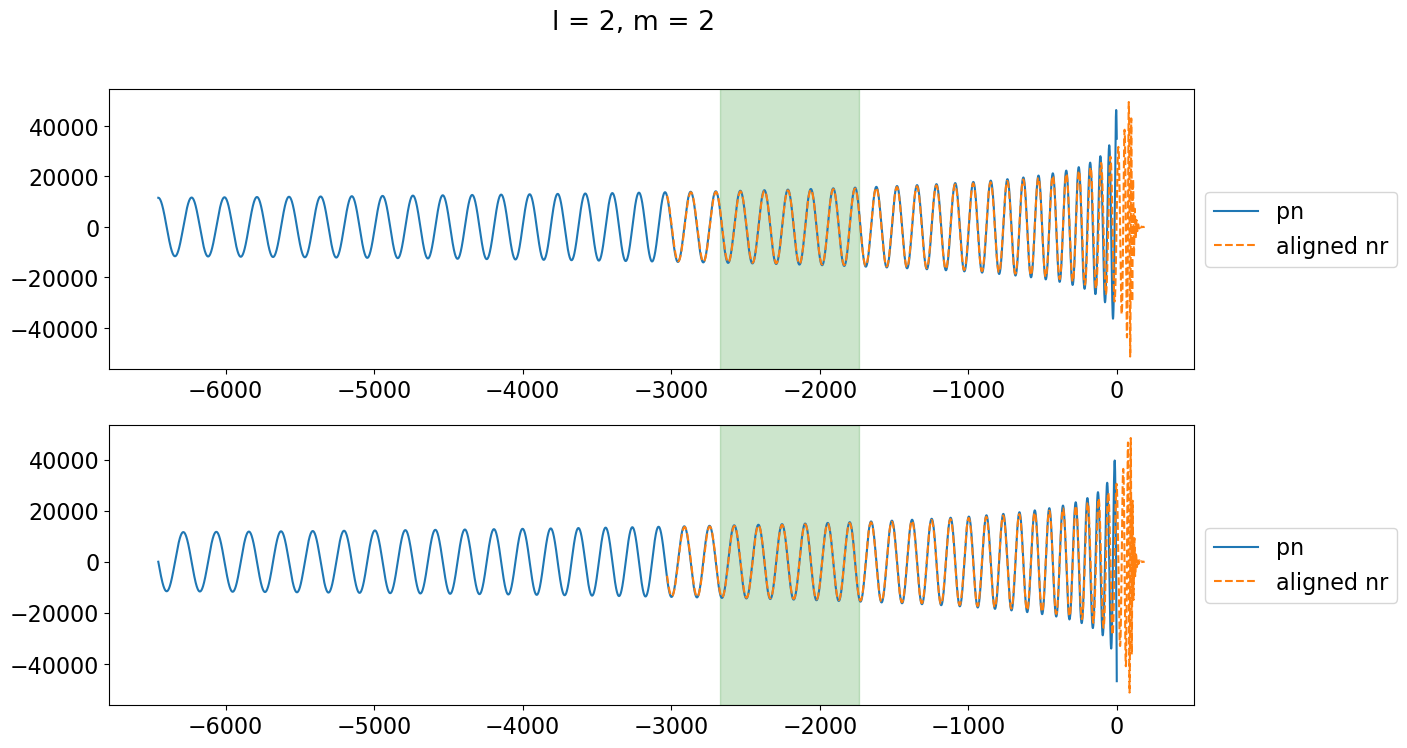

In [138]:
plot_hybrid(ts1, ts2, 2, 2, result, win1, win2)

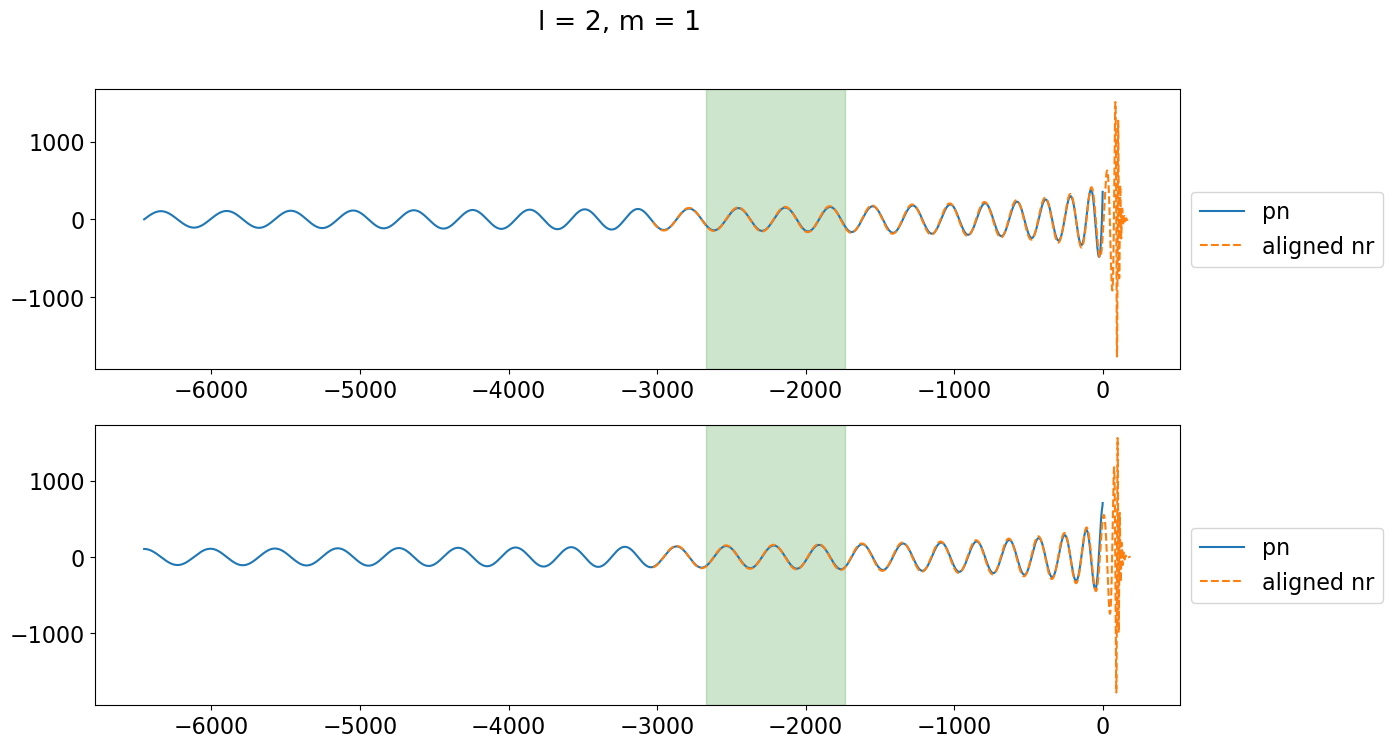

In [139]:
plot_hybrid(ts1, ts2, 2, 1, result, win1, win2)

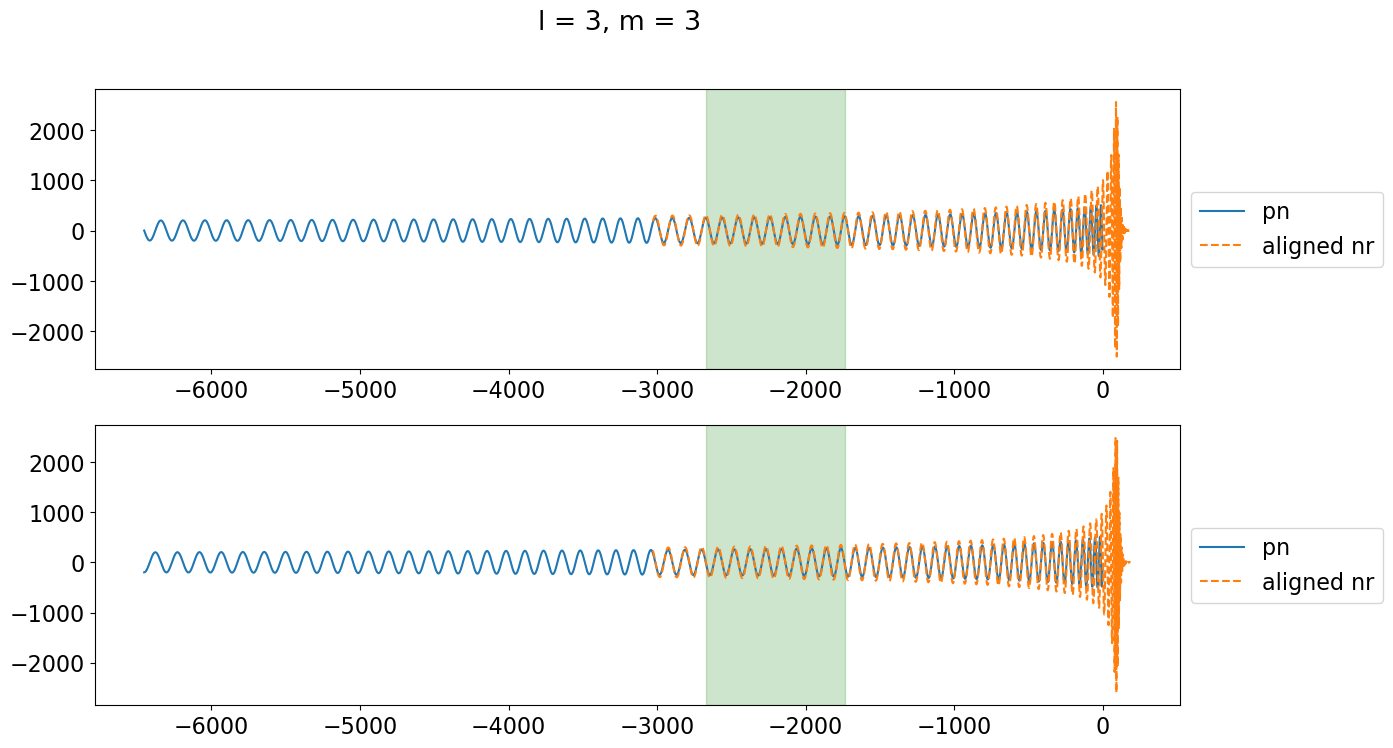

In [140]:
plot_hybrid(ts1, ts2, 3, 3, result, win1, win2)

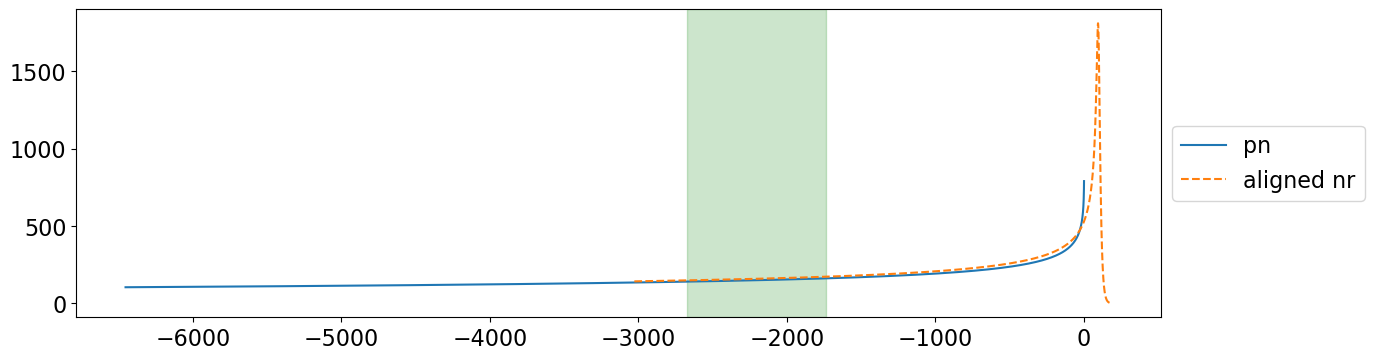

In [141]:
ell=2
mm=1

plt.figure(figsize=(14,4))
plt.plot(ts1.times, np.abs(ts1.hlms[ell,mm]), label='pn')

dt_ = result.params['dt']
dphi_ = result.params['dphi']
dpsi_ = result.params['dpsi']


plt.plot(ts2.times-dt_, np.abs(ts2.hlms[ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)), label='aligned nr', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axvspan(win1, win2, color='g', alpha=0.2)


# plt.xlim(win1+10000, win2+1000)

In [142]:
# next steps
# blend PN and NR in [win1, win2]
# save to disk
# what format and metadata?
# e.g. pn parameters and start frequency
# nr simulation name and file